In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet

import lightgbm as lgb
from catboost import CatBoostRegressor

import mlflow
import shap


/Users/drasokannair/Documents/Akash/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Define some utility functions for errors

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))


def evaluate_regression(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred),
        "rmsle": rmsle(y_true, y_pred)
    }

# Load Data

In [4]:
# Get parent working directory
cwd = Path.cwd()
parent_wd = cwd.parent

In [5]:
train_df = pd.read_csv(f"{str(parent_wd)}/data/DatiumTrain.rpt", sep="\t")
train_df.head(5)

/var/folders/s5/tr0c02592b79cz_d3swk4hvc0000gn/T/ipykernel_13608/3930932226.py:1: DtypeWarning: Columns (27,94) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{str(parent_wd)}/data/DatiumTrain.rpt", sep="\t")


,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,...,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,HOLD,COMMODO,2008,0,0,VE Omega Sedan 4dr. Auto 4sp 3.6i,F,L,...,5500.0,34790.0,White,Perth (WA),Auction,2015-11-03 00:00:00.000,02/2008,93.0,227878.0,2000.0
1,Holden,Commodore,HOLD,COMMODO,1993,7,41,VR Executive Wagon 5dr. Auto 4sp 3.8i,F,L,...,2000.0,27978.0,Red,Belmore (NSW),Auction,2000-10-18 00:00:00.000,08/1993,86.0,153091.0,6800.0
2,Toyota,RAV4,TOYO,RAV4,2012,0,6,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i,F,L,...,15800.0,31990.0,040 - Glacier White (T),Sunshine (VIC),Dealer Only Auction,2014-02-05 00:00:00.000,10/2012,16.0,27374.0,22900.0
3,Holden,Commodore,HOLD,COMMODO,2007,0,11,VZ@VE MY07 Executive Wagon 5dr. Auto 4sp 3.6i,F,L,...,4800.0,35990.0,Quicksilver,Belmore (NSW),Auction,2011-01-10 00:00:00.000,01/2007,48.0,99452.0,10500.0
4,Toyota,Tarago,TOYO,TARAGO,2007,0,0,ACR50R GLi Wagon 8st 5dr Spts Auto 4sp 2.4i,F,L,...,12400.0,49490.0,Silver,Hobart (TAS),Special Fixed Price,2009-05-23 00:00:00.000,01/2007,28.0,44355.0,31320.0


In [38]:
test_df = pd.read_csv(f"{str(parent_wd)}/data/DatiumTest.rpt", sep="\t")
test_df.head(5)

/var/folders/s5/tr0c02592b79cz_d3swk4hvc0000gn/T/ipykernel_13608/2004086338.py:1: DtypeWarning: Columns (27,91) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{str(parent_wd)}/data/DatiumTest.rpt", sep="\t")


,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,...,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
0,Ford,Ranger,FORD,RANGER,2014,0,4,PX XL Hi-Rider Cab Chassis Single Cab 2dr Spts...,F,L,...,20400.0,30740.0,White,Wagga Wagga (NSW),Auction,2017-08-31 00:00:00.000,04/2014,40.0,19963.0,18000.0
1,Toyota,Kluger,TOYO,KLUGER,2015,11,11,GSU55R Grande Wagon 7st 5dr Spts Auto 6sp AWD ...,F,L,...,53400.0,68330.0,218 - Eclipse Black (T),Sunshine (VIC),Dealer Only Auction,2017-05-10 00:00:00.000,02/2016,15.0,13176.0,53250.0
2,Subaru,Liberty,SUBA,LIBERTY,2012,0,1,B5 MY12 2.5i Sedan 4dr Lineartronic 6sp AWD,F,L,...,13500.0,34990.0,Silver,Canberra (ACT),Auction,2016-10-13 00:00:00.000,06/2012,52.0,122080.0,11500.0
3,Jeep,Compass,JEEP,COMPASS,2014,0,4,MK MY14 North Wagon 5dr Spts Auto 6sp 2.0i,F,L,...,18100.0,31000.0,Black,Belmore (NSW),Auction,2016-03-02 00:00:00.000,04/2014,23.0,25177.0,17500.0
4,Mitsubishi,Triton,MITS,TRITON,2011,0,7,MN MY11 GLX Utility Double Cab 4dr Auto 4sp 96...,F,L,...,14700.0,34590.0,White,Belmore (NSW),Auction,2016-12-20 00:00:00.000,10/2011,62.0,49311.0,17100.0


In [7]:
target_col = "Sold_Amount"
random_state = 42
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Transform and drop columns

In [8]:
# Drop rows with missing target 
train_df = train_df.dropna(subset=[target_col])

In [ ]:
# Columns that the assesment brief explicitly mentioned not to use
not_to_use_cols = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax']

# Columns which have post-sale data identified in EDA phase
post_cols = ['NewPrice', 'Sold_Date']

# Columns identified in EDA that do not have much relevance to the vehicle
irrev_cols = ["SaleCategory", 'Branch']

# Columns to drop due to missingness of values
missingness_cols = ['BadgeSecondaryDescription',
 'WheelBaseConfig', 
 'Roofline',
 'PowerRPMFrom',
 'FreeScheduledService',
 'AltEngEngineType',
 'AltEngBatteryType',
 'AltEngCurrentType',
 'AltEngAmpHours',
 'AltEngVolts',
 'AltEngChargingMethod',
 'AltEngPower',
 'AltEngPowerFrom',
 'AltEngPowerTo',
 'AltEngTorque',
 'AltEngTorqueFrom',
 'AltEngTorqueTo',
 'AltEngDrive',
 'NormalChargeMins',
 'QuickChargeMins',
 'NormalChargeVoltage',
 'QuickChargeVoltage',
 'KMRangeElectricEng',
 'ElectricEngineLocation',
 'TopSpeedElectricEng',
 'MaxEthanolBlend',
 'TorqueRPMFrom',
 'EmissionStandard',
 'ExtraIdentification',
 'CO2Urban',
 'CO2ExtraUrban']

# Drop these columns
cols_to_drop = not_to_use_cols + post_cols + irrev_cols + missingness_cols
test_df = test_df.drop(columns=cols_to_drop)

In [10]:
# Transform Compliance Date column
train_df['Compliance_Date'] = pd.to_datetime(train_df['Compliance_Date'], format="%m/%Y",errors='coerce')
train_df['Compliance_Month'] = train_df['Compliance_Date'].dt.month
train_df['Compliance_Year'] = train_df['Compliance_Date'].dt.year

train_df = train_df.drop(columns=["Compliance_Date"])

In [11]:
X = train_df.drop(columns=[target_col])
y = np.log1p(train_df[target_col])

# Impute Missing Values

In [12]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

In [13]:
# For the numerical columns, the standard practice would be to impute with the median value
num_imputer = SimpleImputer(strategy="median")
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [14]:
# For categorical columns, it would be best to set the null values as "Missing" or "Empty" etc.
cat_imputer = SimpleImputer(strategy="constant", fill_value='Missing')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
X[cat_cols] = X[cat_cols].astype(str)

In [15]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Experiment 1: Test Baseline Models

In [17]:
mlflow.sklearn.autolog()

2026/01/09 15:41:56 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.8.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [18]:
mlflow.set_experiment("baseline_models")


for model_name, model in {
    "ridge": Ridge(alpha=1.0, random_state=random_state),
    "elasticnet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=random_state)
}.items():


    with mlflow.start_run(run_name=f"{model_name}_onehot"):
        mlflow.log_params({
            "model": model_name,
            "encoding": "onehot",
            "target_transform": "log1p"
        })


        oof_preds = np.zeros(len(X))
        start = time.time()


        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


            preprocessor = ColumnTransformer([
                ("num", "passthrough", num_cols),
                ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
            ])


            pipe = Pipeline([
                ("prep", preprocessor),
                ("model", model)
            ])


            pipe.fit(X_train, y_train)
            oof_preds[val_idx] = pipe.predict(X_val)


        duration = time.time() - start
        metrics = evaluate_regression(np.expm1(y), np.expm1(oof_preds))


        mlflow.log_metrics(metrics)
        mlflow.log_metric("train_time_sec", duration)

2026/01/09 15:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 10a1e77755bb4bb0b18771c4cd1fa259. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2026/01/09 15:44:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 10a1e77755bb4bb0b18771c4cd1fa259. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/a

🏃 View run ridge_onehot at: http://127.0.0.1:5000/#/experiments/507866700027312039/runs/10a1e77755bb4bb0b18771c4cd1fa259
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/507866700027312039


2026/01/09 15:48:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 879c8cb1bb92410fba9104b35a3e8a03. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
/Users/drasokannair/Documents/Akash/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e+04, tolerance: 7.056e+00
  model = cd_fast.sparse_enet_coordinate_descent

🏃 View run elasticnet_onehot at: http://127.0.0.1:5000/#/experiments/507866700027312039/runs/879c8cb1bb92410fba9104b35a3e8a03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/507866700027312039


# Experiment 2: Different Encoding Methods

In [20]:
mlflow.set_experiment("encoding_comparison")


encoding_strategies = {
    "onehot": OneHotEncoder(handle_unknown="ignore"),
    "ordinal": OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ),
}

for encoding_name, encoder in encoding_strategies.items():

    with mlflow.start_run(run_name=f"lgbm_{encoding_name}"):
        mlflow.log_param("encoding", encoding_name)
        mlflow.log_param("model", "lightgbm")


        oof_preds = np.zeros(len(X))


        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", "passthrough", num_cols),
                ("cat", encoder, cat_cols),
            ],
            remainder="drop"
        )

        X_tr_enc = preprocessor.fit_transform(X_train)
        X_va_enc = preprocessor.transform(X_val)

        mlflow.log_param("n_features", X_tr_enc.shape[1])

        # ---------------------------
        # LightGBM native datasets
        # ---------------------------
        train_data = lgb.Dataset(X_tr_enc, label=y_train)
        val_data = lgb.Dataset(X_va_enc, label=y_val)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "seed": random_state,
        }

        mlflow.log_params(params)

        # ---------------------------
        # Train
        # ---------------------------
        model = lgb.train(
            params,
            train_data,
            num_boost_round=500,
            valid_sets=[train_data, val_data],
            valid_names=["train", "val"],
        )

        # ---------------------------
        # Evaluate
        # ---------------------------
        preds = model.predict(
            X_va_enc,
            num_iteration=model.best_iteration
        )

        metrics = evaluate_regression(
            np.expm1(y_val),
            np.expm1(preds)
        )

        mlflow.log_metrics(metrics)

        # ---------------------------
        # Log model
        # ---------------------------
        mlflow.lightgbm.log_model(model, artifact_path="model")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10374
[LightGBM] [Info] Number of data points in the train set: 40560, number of used features: 2891
[LightGBM] [Info] Start training from score 9.409893


2026/01/09 15:52:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lgbm_onehot at: http://127.0.0.1:5000/#/experiments/856661851063557609/runs/6d7ec988651242b4b66810b96676aa0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/856661851063557609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7655
[LightGBM] [Info] Number of data points in the train set: 40560, number of used features: 85
[LightGBM] [Info] Start training from score 9.409893


2026/01/09 15:53:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lgbm_ordinal at: http://127.0.0.1:5000/#/experiments/856661851063557609/runs/3d3d431012cd4c20a0c4d34f59638f7e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/856661851063557609


# Experiment 3: Testing out different models

In [21]:
mlflow.set_experiment("gbm_model_comparison")


models = {
    "lightgbm_onehot_native": "lightgbm",
    "catboost_native": "catboost"
}

for model_name, model_type in models.items():

    with mlflow.start_run(run_name=model_name):

        mlflow.log_param("model_family", model_name)

        # --------------------------------
        # LightGBM + OneHot (native API)
        # --------------------------------
        if model_type == "lightgbm":

            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", "passthrough", num_cols),
                    ("cat", OneHotEncoder(
                        handle_unknown="ignore"
                    ), cat_cols),
                ],
                remainder="drop"
            )

            X_tr_enc = preprocessor.fit_transform(X_train)
            X_va_enc = preprocessor.transform(X_val)

            mlflow.log_param("encoding", "onehot")
            mlflow.log_param("n_features", X_tr_enc.shape[1])

            train_data = lgb.Dataset(X_tr_enc, label=y_train)
            val_data = lgb.Dataset(X_va_enc, label=y_val)

            params = {
                "objective": "regression",
                "metric": "rmse",
                "learning_rate": 0.05,
                "num_leaves": 31,
                "feature_fraction": 0.8,
                "bagging_fraction": 0.8,
                "bagging_freq": 5,
                "random_state": random_state,
            }

            mlflow.log_params(params)

            model = lgb.train(
                params,
                train_data,
                num_boost_round=500,
                valid_sets=[train_data, val_data],
                valid_names=["train", "val"],
            )

            preds = model.predict(
                X_va_enc,
                num_iteration=model.best_iteration
            )

        # --------------------------------
        # CatBoost (native categoricals)
        # --------------------------------
        else:

            cat_feature_indices = [
                X_train.columns.get_loc(col) for col in cat_cols
            ]

            params = {
                "iterations": 500,
                "depth": 8,
                "learning_rate": 0.05,
                "loss_function": "RMSE",
                "random_seed": random_state
            }

            mlflow.log_param("encoding", "catboost_native")
            mlflow.log_params(params)

            model = CatBoostRegressor(
                **params,
                verbose=False
            )

            model.fit(
                X_train,
                y_train,
                cat_features=cat_feature_indices,
                eval_set=(X_val, y_val),
                use_best_model=True
            )

            preds = model.predict(X_val)

        # --------------------------------
        # Metrics
        # --------------------------------
        metrics = evaluate_regression(
            np.expm1(y_val),
            np.expm1(preds)
        )

        mlflow.log_metrics(metrics)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10374
[LightGBM] [Info] Number of data points in the train set: 40560, number of used features: 2891
[LightGBM] [Info] Start training from score 9.409893
🏃 View run lightgbm_onehot_native at: http://127.0.0.1:5000/#/experiments/445884091791536333/runs/f23ec8d666a94c0d8f1aa29ac1630bce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/445884091791536333
🏃 View run catboost_native at: http://127.0.0.1:5000/#/experiments/445884091791536333/runs/64ff816a21d444c195c30fc4b9d559bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/445884091791536333


In [22]:
from final_model import ModelTrainer

trainer = ModelTrainer(
    iterations=800,
    depth=8,
    learning_rate=0.05
)

final_model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    experiment_name="final_best_model",
    run_name="catboost_production_candidate"
)

2026/01/09 15:55:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run catboost_production_candidate at: http://127.0.0.1:5000/#/experiments/556557940188935892/runs/5dae1072042745718aead2bf076c6a3d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/556557940188935892


# SHAP Feature Importance Summary

The SHAP analysis shows that the model is driven primarily by vehicle age and usage, which aligns well with how vehicles are typically priced in practice.

**Age_Comp_Months** is the most influential feature. As expected, newer vehicles tend to sell for more, while older vehicles see a clear drop in predicted sold amount. This reflects standard depreciation behaviour over time.

**KM (mileage)** is the next strongest driver. Higher mileage generally reduces the predicted price, and its interaction with vehicle age suggests that older vehicles with high usage are penalised more heavily.

Several configuration-related features, such as **RearTyreSize** and **BadgeDescription**, also contribute to the model, likely acting as proxies for trim level, performance, or specification differences between vehicles.

Features related to manufacturing or compliance timing, including **Compliance_Year** and **YearGroup**, show a moderate impact on price, indicating that the production era and regulatory context still play a role in resale value.

Brand-level features such as **Make** and **Series** have a smaller influence compared to age and mileage, suggesting that brand effects are present but secondary to physical depreciation factors. Other categorical attributes (for example fuel type, body style, colour, and drivetrain) have relatively limited individual impact, likely due to overlapping information captured elsewhere in the feature set.

Overall, the **SHAP** results indicate that the model is learning sensible and intuitive pricing drivers, rather than relying on spurious correlations. This increases confidence that the predictions are grounded in meaningful vehicle characteristics and are likely to generalise well.

# Testing model on unseen Test data provided

In [39]:
# CLEARNING

# Columns that the assesment brief explicitly mentioned not to use
not_to_use_cols = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax']

# Columns which have post-sale data identified in EDA phase
post_cols = ['NewPrice', 'Sold_Date']

# Columns identified in EDA that do not have much relevance to the vehicle
irrev_cols = ["SaleCategory", 'Branch']

# Columns to drop due to missingness of values
missingness_cols = ['BadgeSecondaryDescription',
 'WheelBaseConfig', 
 'Roofline',
 'PowerRPMFrom',
 'FreeScheduledService',
 'AltEngEngineType',
 'AltEngBatteryType',
 'AltEngCurrentType',
 'AltEngAmpHours',
 'AltEngVolts',
 'AltEngChargingMethod',
 'AltEngPower',
 'AltEngPowerFrom',
 'AltEngPowerTo',
 'AltEngTorque',
 'AltEngTorqueFrom',
 'AltEngTorqueTo',
 'AltEngDrive',
 'NormalChargeMins',
 'QuickChargeMins',
 'NormalChargeVoltage',
 'QuickChargeVoltage',
 'KMRangeElectricEng',
 'ElectricEngineLocation',
 'TopSpeedElectricEng',
 'MaxEthanolBlend',
 'TorqueRPMFrom',
 'EmissionStandard',
 'ExtraIdentification',
 'CO2Urban',
 'CO2ExtraUrban']

# Drop these columns
cols_to_drop = not_to_use_cols + post_cols + irrev_cols + missingness_cols
test_df = test_df.drop(columns=cols_to_drop)

# Transform Compliance Date column
test_df['Compliance_Date'] = pd.to_datetime(test_df['Compliance_Date'], format="%m/%Y",errors='coerce')
test_df['Compliance_Month'] = test_df['Compliance_Date'].dt.month
test_df['Compliance_Year'] = test_df['Compliance_Date'].dt.year

test_df = test_df.drop(columns=["Compliance_Date"])

In [40]:
num_cols = test_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = test_df.select_dtypes(include="object").columns.tolist()

# For the numerical columns, the standard practice would be to impute with the median value
num_imputer = SimpleImputer(strategy="median")
test_df[num_cols] = num_imputer.fit_transform(test_df[num_cols])

# For categorical columns, it would be best to set the null values as "Missing" or "Empty" etc.
cat_imputer = SimpleImputer(strategy="constant", fill_value='Missing')
test_df[cat_cols] = cat_imputer.fit_transform(test_df[cat_cols])
test_df[cat_cols] = test_df[cat_cols].astype(str)

# Load Best Model and Predict

In [37]:
from catboost import CatBoostRegressor

model_path = str(parent_wd) + f"/mlartifacts/556557940188935892/5dae1072042745718aead2bf076c6a3d/artifacts/model/model.cb"

model = CatBoostRegressor()
model.load_model(model_path)


In [44]:
# Drop rows with missing target 
y_test = test_df[target_col]
X_test = test_df.drop(columns=[target_col])

log_preds = model.predict(X_test)
y_preds = np.expm1(log_preds)


# Analyse Results

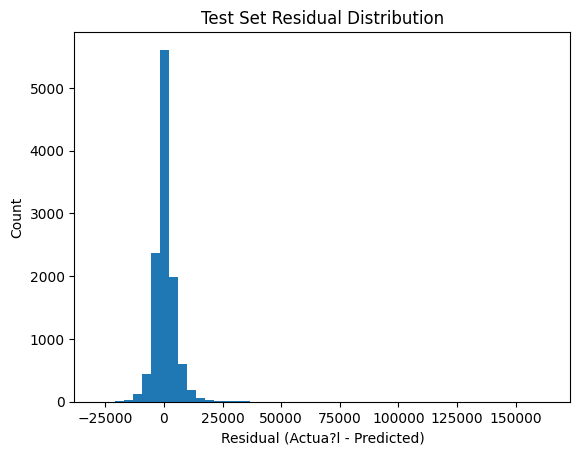

In [45]:
residuals = y_test - y_preds

plt.hist(residuals, bins=50)
plt.title("Test Set Residual Distribution")
plt.xlabel("Residual (Actua?l - Predicted)")
plt.ylabel("Count")
plt.show()


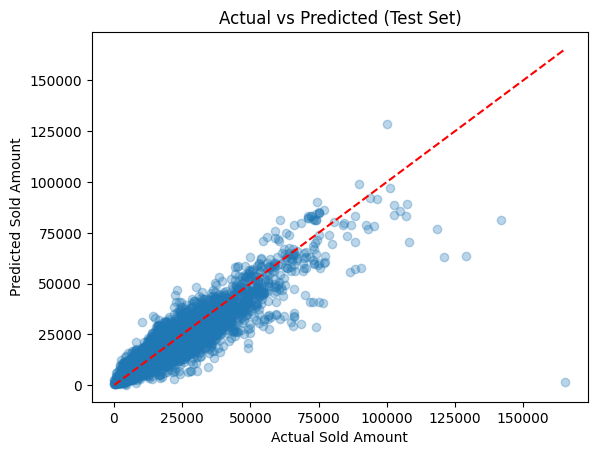

In [47]:
plt.scatter(y_test, y_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Sold Amount")
plt.ylabel("Predicted Sold Amount")
plt.title("Actual vs Predicted (Test Set)")
plt.show()


In [48]:
X_test_eval = X_test.copy()
X_test_eval["Predicted"] = y_preds
X_test_eval["Residual"] = residuals

X_test_eval.groupby(pd.qcut(X_test_eval["KM"], 5))["Residual"].mean()


/var/folders/s5/tr0c02592b79cz_d3swk4hvc0000gn/T/ipykernel_13608/1602792749.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test_eval.groupby(pd.qcut(X_test_eval["KM"], 5))["Residual"].mean()


KM
(1.999, 33504.0]         635.588982
(33504.0, 59038.4]       139.400154
(59038.4, 87757.2]      -130.378800
(87757.2, 127564.2]     1440.522860
(127564.2, 520165.0]     548.771997
Name: Residual, dtype: float64

Segment-level residual analysis by mileage shows that the model performs best in the mid-mileage range (approximately 30k–90k KM), where average errors are close to zero.

For very low and very high mileage vehicles, the model tends to slightly under-predict sale prices. This suggests that mileage alone may not fully capture value differences at the extremes, where factors such as vehicle condition, brand perception, or usage profile may play a stronger role.

Overall, the error pattern is stable and monotonic, indicating predictable behaviour rather than erratic model performance.

# Test Set Evaluation

The final model was evaluated on the provided test dataset, which includes observed Sold_Amount values. Predictions were generated using the trained CatBoost model and compared directly against actual sale prices using the same evaluation metrics applied during training.

Performance on the test set is broadly consistent with validation results, indicating that the model generalises well to unseen data. Residual analysis shows a near-centred error distribution, with larger errors concentrated in higher-priced vehicles, which is expected given the heavier tails in the price distribution.

Segment-level analysis suggests slightly higher underestimation for vehicles with very high mileage and mild overestimation for newer vehicles, highlighting areas where additional feature refinement or segment-specific modelling could further improve performance.

Given that the test set represents a true holdout, these results provide a realistic estimate of expected model performance in production.